In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Currently data is in directories like

In [3]:
# Try a new CNN with the input data augmented so it will classify obscured spheres
# https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

#########################################################
# With this the whole file structure had to be changed.
# TODO Use code for test train split, currently the last 10 or so files are used as test, not randomly
#   For test/train split
#       get list of positives and negatives, test/train split the list.
#       move all filenames in that list to either test, or train directory
#########################################################

from keras.preprocessing.image import ImageDataGenerator

# This code just makes a few examples of the augmented image, good for my understanding but can be commented out.
'''
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        #rescale=1./255,
        width_shift_range=0.0,
        height_shift_range=0.0, # From 0.2 to 0 ONLY MIDDLE
        shear_range=0.2,
        zoom_range=[1,4],       # Changed to zoom out 5 -> 4 was too good
        horizontal_flip=True)

img = load_img('TrainingImages/positives/positivePatch_304.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (51, 51, 3)
x = x.reshape((1,) + x.shape)  # np array with shape (1, 51, 51, 3)

# Save example images if you want to see whats happening inside
i = 0
for batch in datagen.flow(x, batch_size=1, save_to_dir='TrainingImages', save_prefix='augmented', save_format='jpg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely
'''

Using TensorFlow backend.


"\nfrom keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img\n\ndatagen = ImageDataGenerator(\n        #rescale=1./255,\n        width_shift_range=0.0,\n        height_shift_range=0.0, # From 0.2 to 0 ONLY MIDDLE\n        shear_range=0.2,\n        zoom_range=[1,4],       # Changed to zoom out 5 -> 4 was too good\n        horizontal_flip=True)\n\nimg = load_img('TrainingImages/positives/positivePatch_304.jpg')  # this is a PIL image\nx = img_to_array(img)  # this is a Numpy array with shape (51, 51, 3)\nx = x.reshape((1,) + x.shape)  # np array with shape (1, 51, 51, 3)\n\n# Save example images if you want to see whats happening inside\ni = 0\nfor batch in datagen.flow(x, batch_size=1, save_to_dir='TrainingImages', save_prefix='augmented', save_format='jpg'):\n    i += 1\n    if i > 20:\n        break  # otherwise the generator would loop indefinitely\n"

In [4]:
# CNN has been trained previously, just loading in weights so commented out
'''
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

# Made this into a function so that I can rerun and load weights
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(51, 51, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

########################################################## New Cell? #########################################

batch_size = 16 # TODO find out what batch_size is

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        width_shift_range=0.0,
        height_shift_range=0.0, # From 0.2 to 0 ONLY MIDDLE
        shear_range=0.2,
        zoom_range=[1,4],       # Changed to zoom out 5 -> 4 was too good
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'TrainingImages/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'TrainingImages/train',  # this is the target directory
        target_size=(51, 51),  # all images will be resized to 51x51
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        'TrainingImages/test',
        target_size=(51, 51),
        batch_size=batch_size,
        class_mode='binary')

# TODO search more about these hyperparameters
# steps_per_epoch???? 

model.fit_generator(
        train_generator,
        steps_per_epoch=2000 // batch_size,
        epochs=5,       # Can Increase later but I dont think more epochs really help it
        validation_data=validation_generator,
        validation_steps=800 // batch_size)

model.save('CNN_Model.h5')
'''

"\nfrom keras.models import Sequential\nfrom keras.layers import Conv2D, MaxPooling2D\nfrom keras.layers import Activation, Dropout, Flatten, Dense\n\n# Made this into a function so that I can rerun and load weights\nmodel = Sequential()\nmodel.add(Conv2D(32, (3, 3), input_shape=(51, 51, 3)))\nmodel.add(Activation('relu'))\nmodel.add(MaxPooling2D(pool_size=(2, 2)))\n\nmodel.add(Conv2D(32, (3, 3)))\nmodel.add(Activation('relu'))\nmodel.add(MaxPooling2D(pool_size=(2, 2)))\n\nmodel.add(Conv2D(64, (3, 3)))\nmodel.add(Activation('relu'))\nmodel.add(MaxPooling2D(pool_size=(2, 2)))\n\nmodel.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors\nmodel.add(Dense(64))\nmodel.add(Activation('relu'))\nmodel.add(Dropout(0.5))\nmodel.add(Dense(1))\nmodel.add(Activation('sigmoid'))\n\nmodel.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])\n\n########################################################## New Cell? #########################################\

In [5]:
# Load model
from tensorflow import keras

model = keras.models.load_model('CNN_Model.h5')

# Classifier is trained
Now the classifier has been sufficiently trained we can use it on the pacman data

1 - First I will define the functions I created for the task

2 - Then I will use the PacMan code to play the game 

In [6]:

############### OLD BUT KEPT FOR REFERENCE #####################
# Define function sliding window
# returns array of windows that I can classify at once
def sliding_window( step_size, image ):
    #image is (160, 240, 3)
    #window is (51, 51, 3)
    image_hight = image.shape[0] # 160
    image_width = image.shape[1] # 240
    window_size = 51
    windows = []

    for y in range(0, image_hight-window_size, step_size):   # Verticle
        for x in range (0, image_width-window_size, step_size):   #horizontal
            windows.append(image[y:y+window_size, x:x+window_size, :])
    print('Number of windows: {}'.format(len(windows)))

    return np.array(windows) # Return windows as np array

# This function is an extention of the sliding_window function
# The function takes in
# Prints 
# Returns the x,y coordinates of all the possible spheres ?????  
def sliding_window_classifier( step_size, image ):
    #image is (160, 240, 3)
    #window is (51, 51, 3)
    image_hight = image.shape[0] # 160
    image_width = image.shape[1] # 240
    window_size = 51
    windows = []    # Dont do anything with windows ?
    result = []

    for y in range(0, image_hight-window_size, step_size): 
        for x in range (0, image_width-window_size, step_size):

            window = image[y:y+window_size, x:x+window_size, :]

            #Normaly you predict on an array of value, but here we want the (x,y) coordinates and this is easier
            window = np.expand_dims(window, axis=0) # Adds first dimension to data (1,51,51,3) -> (1,51,51,3) # MIGHT get not np error
            prediction = model.predict( np.array( window ) )
            prediction = prediction[0][0] #  Unpack prediction [[1.]] -> 1

            if (prediction > 0.3):
                # SECTION FOR DEBUGGING PURPOSES
                #print('Coordinates: X:{}, Y:{}'.format(x,y))
                print('Prediction percentage: {} \n'.format(prediction))   #
                print('Middle pixel Depth: {}'.format(depth[y+26, x+26]))   # TODO call depth as a parameter or ensure it is correct
                # Find depth look at the middle

                # 26 IS MIDDLE PIXEL
                #TODO Draw a rectangle over these                 
                print('Middle 4:')
                print(depth[ y+25:y+27, x+25:x+27 ])    # IS THIS IN THE MIDDLE OR OF TO THE SIDE
                                                        # GET MIN/MODE OF THIS
                print('Middle 8:')
                print(depth[ y+24:y+28, x+24:x+28 ])    # IS THIS IN THE MIDDLE OR OF TO THE SIDE
                                                        # GET MIN/MODE OF THIS
                plt.figure(figsize=(8,4))
                plt.title('Image')
                plt.imshow( window[0,:,:,:] )   
                from matplotlib.patches import Rectangle
                ax=plt.gca()    # gca=get_current_axes?
 

                # Middle 4      1x1 either side
                ax.add_patch(Rectangle((24,24), width=2, height=2,linewidth=1,edgecolor='g',facecolor='none'))  
                # Middle 16     2x2 either side
                ax.add_patch(Rectangle((23,23), width=4, height=4,linewidth=1,edgecolor='y',facecolor='none')) 
                # Middle 36     3x3 either side
                ax.add_patch(Rectangle((22,22), width=6, height=6,linewidth=1,edgecolor='g',facecolor='none'))
                # Middle 64     4x4 either side
                ax.add_patch(Rectangle((21,21), width=8, height=8,linewidth=1,edgecolor='y',facecolor='none'))  

                ax.spines['left'].set_position('center')
                ax.spines['bottom'].set_position('center')
                #ax.xaxis.set_ticks([])
                #ax.yaxis.set_ticks([])  # Remove ticks
                ax.xaxis.set_ticks_position('bottom')
                ax.yaxis.set_ticks_position('left')
                plt.show()

                plt.figure(figsize=(4,2))
                plt.title('Depth')
                plt.imshow( depth[y:y+51, x:x+51] )    
                plt.colorbar()
                plt.show()
                print('########################################')
                print()
                # SECTION FOR DEBUGGING PURPOSES

                middle_depth = depth[y+25, x+25]

                if (prediction > 0.99): # Need to be at least 99% to add to list
                    result.append( (x, y, prediction, middle_depth) )
                    #return (x,y)    # WILL ONLY PRINT FIRST ONE TODO PRINT VECTOR OF x,y s

    # Results are np array with columns: X, Y, Prediction
    return np.asarray(result)#np.concatenate(result).reshape(-1,4)    # If len(coordinates)==0 then no spheres were found
# TODO WITH ABOVE MOVE TO HIGHEST PREDICITION, THEN CLOSEST BALL
# Maybe use pandas for that too

# Not for task but function to nicely visualise allmaps
def visualise_maps(image, mapx, mapy, mapz, depth):
    # Inputs can be full 160x240 or 51x51 in size
    fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20,3))

    ax[0].set_title('image')
    im0 = ax[0].imshow(image)
    #fig.colorbar(im, ax=ax[0])

    ax[1].set_title('mapx')
    im1 = ax[1].imshow(mapx, cmap='bwr')
    fig.colorbar(im1, ax=ax[1])

    ax[2].set_title('mapy')
    im2 = ax[2].imshow(mapy, cmap='bwr')
    fig.colorbar(im2, ax=ax[2])

    ax[3].set_title('mapz')
    im3 = ax[3].imshow(mapz, cmap='bwr')
    fig.colorbar(im3, ax=ax[3])

    ax[4].set_title('depth')
    im4 = ax[4].imshow(depth, cmap='bwr')
    fig.colorbar(im4, ax=ax[4])
    plt.show()
    print()


# This will change a lot
# First draft here to make code less messy
def sphere_position(x, y, cur_position, spheres_collected):
    # x,y
    # Given coordinates of sphere, 
    #   find x, y, z of sphere
    #   set that as position

    # For now going with move to middle pixel

    newx = mapx[y+25, x+25] #-0.2603576553033593    # I want Y, X not X, Y 
    newy = mapy[y+25, x+25] #0.04575819465891324
    newz = mapz[y+25, x+25] #2.330109222847228

    # 'I won't give too much away, but I will say that you will not need to be rounding any numbers to find your detection in 3D space'
    # Keep for now anyone
    newx = np.round(newx, decimals=2) #-0.26
    newy = np.round(newy, decimals=2) #0.04
    newz = np.round(newz, decimals=2) #2.33
    # TODO Idea: add half of the width of a sphere so I appear in the centre of sphere?

    print('I am at position [{0}, {1}, {2}]'.format(*cur_position))
    print('I have found {0} out of {1} spheres!\n'.format(np.sum(spheres_collected), len(spheres_collected)));

    # Move position and update scene
    position = np.asarray([newx, newy, newz])
    print('I am now at position [{0}, {1}, {2}]'.format(*position))

    #IndexError: index 0 is out of bounds for axis 0 with size 0 -> error with spheres_collected normally
    global_cloud, spheres_collected = PacMan.update_scene(position, spheres_collected);
    print('I have found {0} out of {1} spheres!\n'.format(np.sum(spheres_collected), len(spheres_collected)));

    #print([newx, newy, newz])

    # Fixed error where spheres_collected wouldnt update as it wasnt returned
    return global_cloud, spheres_collected, position

In [7]:
%%time
# 1.11s
# Initilise game
import PacMan_functionality as PacMan
global_cloud, spheres_collected = PacMan.startup_scene()    # Have to use subsample, it effects acuracy but its way too slow otherwise
position = np.asarray([0, 0, 0])
angle = np.asarray([0, 0, 0])

Wall time: 1.53 s


In [8]:
%%time
# 5min 41s
# Obtain image and associated maps
image, mapx, mapy, mapz, depth = PacMan.project_pointcloud_image(global_cloud, angle, position)

Wall time: 2min 51s


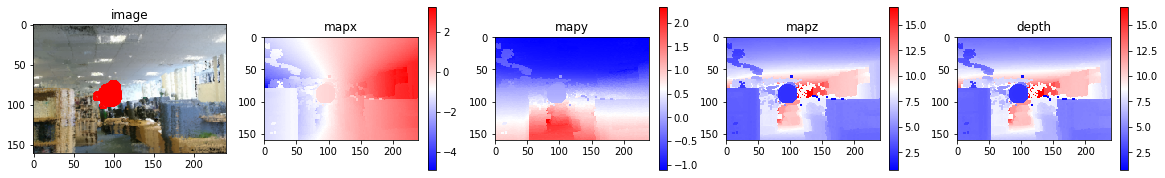

In [ ]:
%%time
# Visualise world before we move
visualise_maps(image, mapx, mapy, mapz, depth)

# Attemp to find spheres
res = sliding_window_classifier(20, image)  # Return list of x,y,predict,depth
print(res)

# Get x,y of sphere with minimum depth aka closest sphere
min_index = np.argmin(res[:,3]) #npres [:,3] is list of depths. argmin is index of min depth
x = int(res[min_index, 0])    # From float to int
y = int(res[min_index, 1])    

global_cloud, spheres_collected, position = sphere_position(x, y, position, spheres_collected)    # Get spacial coordinates of new sphere
# and move there apparantly

In [ ]:
%%time
# Get new images
image, mapx, mapy, mapz, depth = PacMan.project_pointcloud_image(global_cloud, angle, position)

In [ ]:
%%time
# Visualise world before we move
visualise_maps(image, mapx, mapy, mapz, depth)

# Attemp to find spheres
res = sliding_window_classifier(20, image)  # Return list of x,y,predict,depth
print(res)

# Get x,y of sphere with minimum depth aka closest sphere
min_index = np.argmin(res[:,3]) #npres [:,3] is list of depths. argmin is index of min depth
print('Minimum depth: {}'.format( np.min(res[:,3]) ))
x = int(res[min_index, 0])    # From float to int
y = int(res[min_index, 1])    

global_cloud, spheres_collected, position = sphere_position(x, y, position, spheres_collected)    # Get spacial coordinates of new sphere
# and move there apparantly

In [ ]:
%%time
# Get new images
image, mapx, mapy, mapz, depth = PacMan.project_pointcloud_image(global_cloud, angle, position)

In [ ]:
#################### BEFORE ABOVE CRASHED BUT WITH CHANGES TO CODE IT SHOULD JUST MOVE TO THE POSITION NOW

In [ ]:
%%time
# Visualise world before we move
visualise_maps(image, mapx, mapy, mapz, depth)

# Attemp to find spheres
res = sliding_window_classifier(20, image)  # Return list of x,y,predict,depth
print(res)

# Get x,y of sphere with minimum depth aka closest sphere
min_index = np.argmin(res[:,3]) #npres [:,3] is list of depths. argmin is index of min depth
print('Minimum depth: {}'.format( np.min(res[:,3]) ))
x = int(res[min_index, 0])    # From float to int
y = int(res[min_index, 1])    
print('X: {}, Y: {}'.format( x, y) )

global_cloud, spheres_collected, position = sphere_position(x, y, position, spheres_collected)    # Get spacial coordinates of new sphere
# and move there apparantly

In [ ]:
%%time
# Get new images
image, mapx, mapy, mapz, depth = PacMan.project_pointcloud_image(global_cloud, angle, position)

In [ ]:
#%%time
# Visualise world before we move
visualise_maps(image, mapx, mapy, mapz, depth)

# Attemp to find spheres
res = sliding_window_classifier(20, image)  # Return list of x,y,predict,depth
print(res)

# Get x,y of sphere with minimum depth aka closest sphere
min_index = np.argmin(res[:,3]) #npres [:,3] is list of depths. argmin is index of min depth
print('Minimum depth: {}'.format( np.min(res[:,3]) ))
x = int(res[min_index, 0])    # From float to int
y = int(res[min_index, 1])    
print('X: {}, Y: {}'.format( x, y) )

global_cloud, spheres_collected, position = sphere_position(x, y, position, spheres_collected)    # Get spacial coordinates of new sphere
# and move there apparantly

In [ ]:
%%time
# Get new images
image, mapx, mapy, mapz, depth = PacMan.project_pointcloud_image(global_cloud, angle, position)

In [ ]:
#%%time
# Visualise world before we move
visualise_maps(image, mapx, mapy, mapz, depth)

# Attemp to find spheres
res = sliding_window_classifier(20, image)  # Return list of x,y,predict,depth
print(res)

# Get x,y of sphere with minimum depth aka closest sphere
min_index = np.argmin(res[:,3]) #npres [:,3] is list of depths. argmin is index of min depth
print('Minimum depth: {}'.format( np.min(res[:,3]) ))
x = int(res[min_index, 0])    # From float to int
y = int(res[min_index, 1])    
print('X: {}, Y: {}'.format( x, y) )

global_cloud, spheres_collected, position = sphere_position(x, y, position, spheres_collected)    # Get spacial coordinates of new sphere
# and move there apparantly

In [ ]:
# Ignore error thats just error when no sphere is called.
# Now we can detect the first row of spheres
# Now look at the pointcloud to assess the situation.

In [ ]:
%%time
# matplotlib functionality wrapped by PacMan_functionality
PacMan.show_point_cloud(global_cloud, subsample=50)

# pptk pointcloud viewer
import pptk
pptk.viewer(global_cloud['Positions'], global_cloud['Colors']/255.0)

In [ ]:
%%time
# At this point I want to look to my left 45 degres ish
# Think that is changeing the z axes
# Position is ZYX, so increase z to pi/4 π/4

(np.pi/4) 

new_angle = np.asarray([0, -np.pi/4, 0]) # Rotate to left slightly?

# Get new images
image, mapx, mapy, mapz, depth = PacMan.project_pointcloud_image(global_cloud, new_angle, position)

visualise_maps(image, mapx, mapy, mapz, depth)